Poisson model from 
https://docs.pymc.io/notebooks/getting_started.html

## ==== Install and import modules ====

In [1]:
# Run this the first time you load this notebook
# Once it finishe running, go to Runtime > Restart Runtime
# Once Runtime restarts, continue running cells in order (including this one)
import shutil
if not shutil.which("arviz"):
    !pip install -q --upgrade arviz
if not shutil.which("pymc3"):
    !pip install -q --upgrade pymc3

     |████████████████████████████████| 1.6MB 8.1MB/s 
     |████████████████████████████████| 768kB 33.5MB/s 
     |████████████████████████████████| 4.7MB 45.7MB/s 
     |████████████████████████████████| 317kB 58.3MB/s 
     |████████████████████████████████| 870kB 8.2MB/s 
     |████████████████████████████████| 1.8MB 17.1MB/s 


In [109]:
import pymc3 as pm
from scipy.stats import linregress
import numpy as np
import pylab as plt
from joblib import cpu_count
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## ==== Poisson Changepoint Model ====

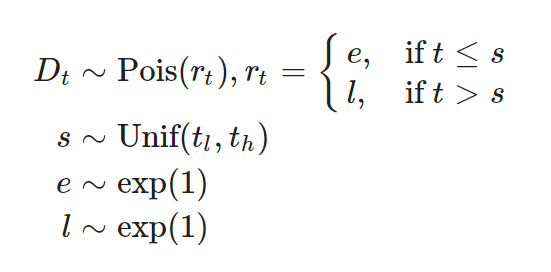

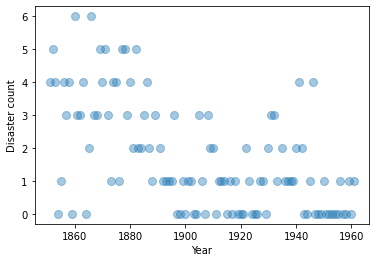

In [3]:
## Define Data
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");


In [4]:
with pm.Model() as disaster_model:

    # Uniform Prior on switchpoint location --> We think it can be anywhere
    # between the minimum and maximum times
    # "testval" = Our guess of where it could be, useful if dataset is small
    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    # While statement (switchpoint >= years) is false, use early rate
    # if true, use late rate
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    # Data modelled as poisson distribution with the given rate
    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

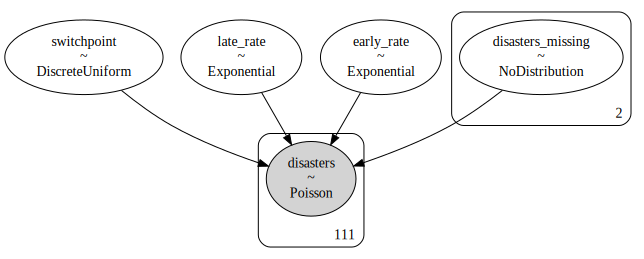

In [34]:
# Plot the graph for the model
pm.model_to_graphviz(disaster_model)

In [93]:
# Run inference on the model
with disaster_model:
    disaster_trace = pm.sample(3000, cores=cpu_count())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 10 seconds.
The number of effective samples is smaller than 10% for some parameters.


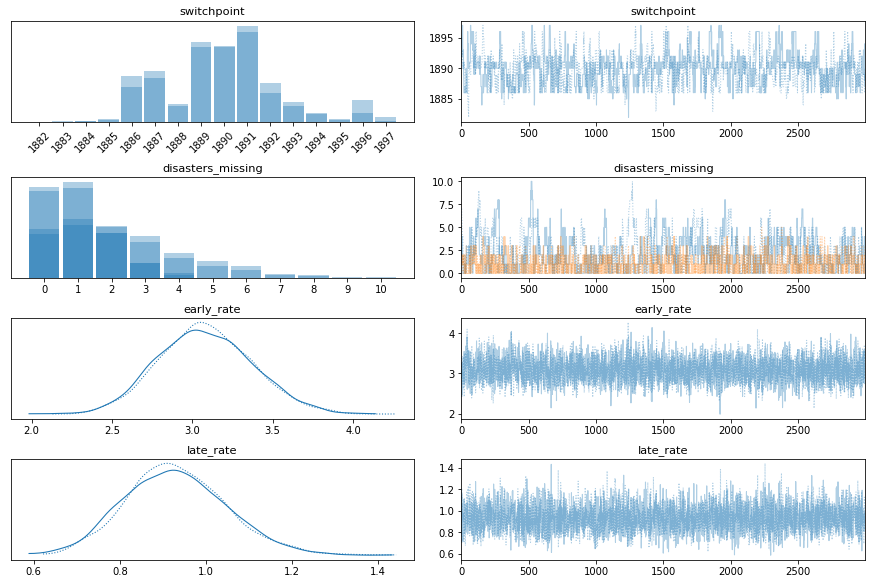

In [94]:
# Plot inferred distributions
ax = pm.traceplot(disaster_trace);
plt.setp(ax[0,0].xaxis.get_majorticklabels(), rotation=45);

In [95]:
# Sample OBSERVATIONS from the posterior distribution, using the paramters as determined by the trace
with disaster_model:
  disaster_ppc = pm.sample_posterior_predictive(disaster_trace, 1000)
mean_ppc, std_ppc = np.mean(disaster_ppc['disasters'],axis=0),np.std(disaster_ppc['disasters'],axis=0)
mean_switch,std_switch = disaster_trace["switchpoint"].mean(), disaster_trace["switchpoint"].std()

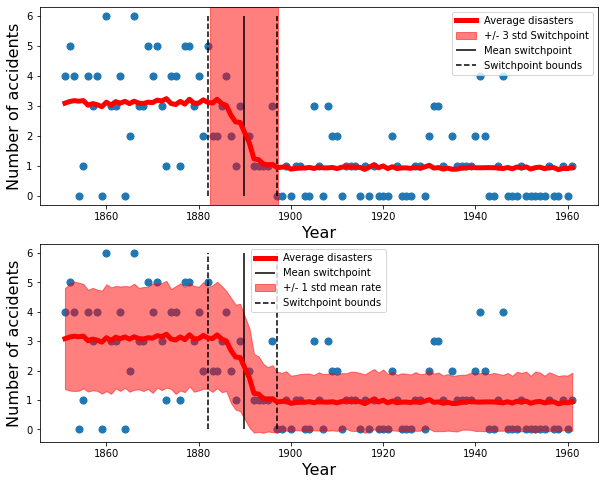

In [98]:
fig, ax = plt.subplots(2,1,figsize=(10, 8))

ax[0].scatter(years, disaster_data, marker = ".", s = 200)
ax[0].set_ylabel("Number of accidents", fontsize=16)
ax[0].set_xlabel("Year", fontsize=16)

ax[0].vlines(mean_switch, disaster_data.min(), disaster_data.max(), 
           color="k", label = 'Mean switchpoint')

ax[0].vlines(disaster_trace["switchpoint"].min(), disaster_data.min(), disaster_data.max(), 
           color="k", linestyles = 'dashed')
ax[0].vlines(disaster_trace["switchpoint"].max(), disaster_data.min(), disaster_data.max(), 
           color="k", label = 'Switchpoint bounds', linestyles = 'dashed')
ax[0].axvspan(mean_switch-3*std_switch, mean_switch+3*std_switch, alpha = 0.5, 
            color='r', label = '+/- 3 std Switchpoint')
ax[0].plot(years, mean_ppc, label = 'Average disasters', c='red', lw=5)
ax[0].legend()

ax[1].scatter(years, disaster_data, marker = ".", s = 200)
ax[1].set_ylabel("Number of accidents", fontsize=16)
ax[1].set_xlabel("Year", fontsize=16)
ax[1].vlines(mean_switch, disaster_data.min(), disaster_data.max(), 
           color="k", label = 'Mean switchpoint')
ax[1].plot(years, mean_ppc, label = 'Average disasters', c='red', lw=5)
ax[1].fill_between(years, mean_ppc-std_ppc, mean_ppc+std_ppc, 
                   label = '+/- 1 std mean rate', color='red', alpha = 0.5)
ax[1].vlines(disaster_trace["switchpoint"].min(), disaster_data.min(), disaster_data.max(), 
           color="k", linestyles = 'dashed')
ax[1].vlines(disaster_trace["switchpoint"].max(), disaster_data.min(), disaster_data.max(), 
           color="k", label = 'Switchpoint bounds', linestyles = 'dashed')
ax[1].legend()

## ==== Bernoulli Changepoint Model ====

Text(0, 0.5, 'Spikes')

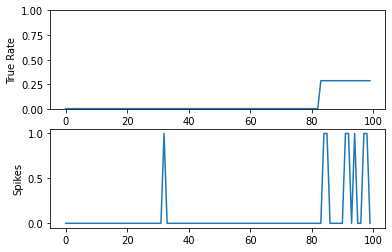

In [102]:
## Generate data
# Some poisson spiking
length = 100
timepoints = np.arange(length)

# Randomly pick changepoint position
true_tau = np.int(np.random.uniform(0,length))
# Randomly pick firing rate for before and after changepoint
true_lambda = np.random.random(2)

# Create firing rate for every timepoint
true_r = np.ones(length)
true_r[true_tau:] *= true_lambda[0]
true_r[:true_tau] *= true_lambda[1]
  
# Create spikes using firing rate
spikes = np.random.random(length) < true_r

fig,ax = plt.subplots(2,1)
ax[0].plot(true_r)
ax[0].set_ylim(0,1)
ax[1].plot(spikes)
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")

In [103]:
with pm.Model() as spiking_model:

    ## ** Compare model to poisson model above
    ## Structure is EXACTLY the same, distribution are different
    ## No equation solving needed to fit different kind of data :)

    # Uniform Prior on switchpoint location --> We think it can be anywhere
    # between the minimum and maximum times
    # "testval" = Our guess of where it could be, useful if dataset is small
    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=timepoints.min(), upper=timepoints.max(), 
        testval=np.mean(timepoints))

    # Priors for pre- and post-switch rates number of disasters
    # Change rate priors to Beta (support 0-1), as parameter for Bernoulli
    # can only go from 0-1. Exponential goes from 0->+inf so is inappropriate.
    early_rate = pm.Beta("early_rate", 1, 1)
    late_rate = pm.Beta("late_rate", 1, 1)

    # Allocate appropriate Poisson rates to years before and after current
    # While statement (switchpoint >= years) is false, use early rate
    # if true, use late rate
    rate = pm.math.switch(switchpoint >= timepoints, early_rate, late_rate)

    # Data modelled as Bernoulli distribution with the given rate
    # "CAN" be modelled as poisson but Bernoulli is more appropriate
    spiking = pm.Bernoulli("spikes", rate, observed=spikes)

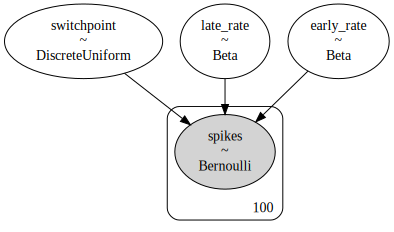

In [104]:
# Plot the graph for the model
pm.model_to_graphviz(spiking_model)

In [105]:
# Run inference on the model
with spiking_model:
    trace = pm.sample(3000, cores=cpu_count())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 9 seconds.
The number of effective samples is smaller than 10% for some parameters.


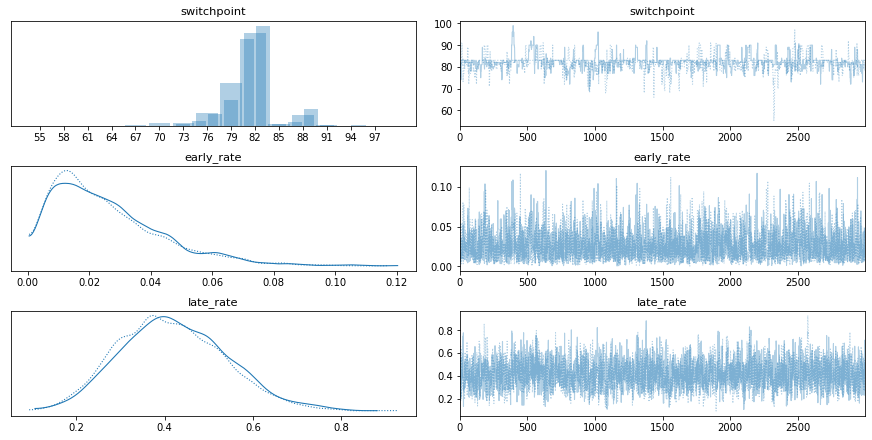

In [106]:
# Plot inferred distributions
ax = pm.traceplot(trace);

In [107]:
# Sample OBSERVATIONS from the posterior distribution, using the paramters as determined by the trace
with spiking_model:
  ppc = pm.sample_posterior_predictive(trace, 1000)
mean_ppc, std_ppc = np.mean(ppc['spikes'],axis=0),np.std(ppc['spikes'],axis=0)
mean_switch,std_switch = trace["switchpoint"].mean(), trace["switchpoint"].std()

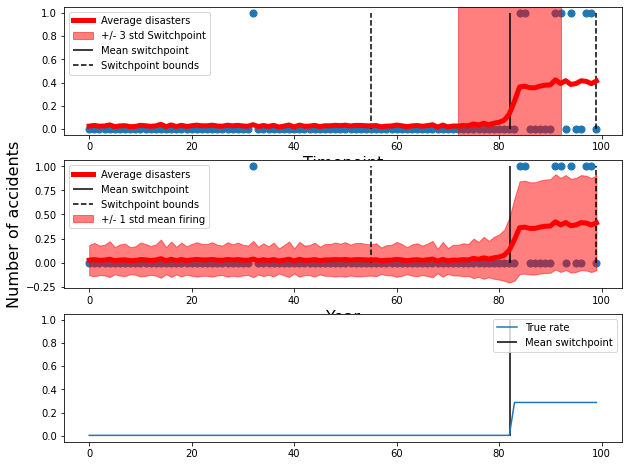

In [108]:
fig, ax = plt.subplots(3,1,figsize=(10, 8))

ax[0].scatter(timepoints, spikes, marker = ".", s = 200)
ax[0].set_xlabel("Timepoint", fontsize=16)

ax[0].vlines(mean_switch, spikes.min(), spikes.max(), 
           color="k", label = 'Mean switchpoint')

ax[0].vlines(trace["switchpoint"].min(), spikes.min(), spikes.max(), 
           color="k", label = 'Switchpoint bounds', linestyles = 'dashed')
ax[0].vlines(trace["switchpoint"].max(), spikes.min(), spikes.max(), 
           color="k", linestyles = 'dashed')
ax[0].axvspan(mean_switch-3*std_switch, mean_switch+3*std_switch, alpha = 0.5, 
            color='r', label = '+/- 3 std Switchpoint')
ax[0].plot(timepoints, mean_ppc, label = 'Average disasters', c='red', lw=5)
ax[0].legend()

ax[1].scatter(timepoints, spikes, marker = ".", s = 200)
ax[1].set_ylabel("Number of accidents", fontsize=16)
ax[1].set_xlabel("Year", fontsize=16)
ax[1].vlines(mean_switch, spikes.min(), spikes.max(), 
           color="k", label = 'Mean switchpoint')
ax[1].vlines(trace["switchpoint"].min(), spikes.min(), spikes.max(), 
           color="k", linestyles = 'dashed')
ax[1].vlines(trace["switchpoint"].max(), spikes.min(), spikes.max(), 
           color="k", label = 'Switchpoint bounds', linestyles = 'dashed')
ax[1].plot(timepoints, mean_ppc, label = 'Average disasters', c='red', lw=5)
ax[1].fill_between(timepoints, mean_ppc-std_ppc, mean_ppc+std_ppc, 
                   label = '+/- 1 std mean firing', color='red', alpha = 0.5)
ax[1].legend()

ax[2].plot(true_r,label = 'True rate')
ax[2].vlines(mean_switch, spikes.min(), spikes.max(), 
           color="k", label = 'Mean switchpoint')
ax[2].legend()
